<a href="https://colab.research.google.com/github/hida0/ESAA/blob/HW/Week11_HW1_%EB%B6%84%EB%A5%98%EC%8B%A4%EC%8A%B5_%EC%82%B0%ED%83%84%EB%8D%B0%EB%A5%B4%EA%B3%A0%EA%B0%9D%EB%A7%8C%EC%A1%B1_%EC%8B%A0%EC%9A%A9%EC%B9%B4%EB%93%9C%EC%82%AC%EA%B8%B0%EA%B2%80%EC%B6%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 개념 정리 & 필사
(파이썬 머신러닝 완벽 가이드 ch4. 8-9 pg. 252-277)
### 분류 실습 - 캐글 산탄데르 고객 만족 예측
- 캐글의 산탄데르 고객 만족 데이터 세트에 대해서 고객 만족 여부를 XGBoost와 LightGBM을 활용하여 예측한다.
- 데이터는 존재하는 370개의 피처를 기반으로 고객 만족 여부를 예측하며, 예측 클래스 레이블 명은 TARGET으로 이 값이 1이면 불만을 가진 고객이고 0이면 만족한 고객이다.
- 대부분이 만족이고 일부만 불만족인 데이터는 정확도 수치보다 ROC-AUC가 더 적합하므로 **모델의 성능 평가는 ROC-AUC로 평가**한다.


### 분류 실습 - 캐글 산탄데르 고객 만족 예측
### 1. 데이터 전처리
- 데이터는 371개의 칼럼을 가지고 있으며, 111개의 피처가 float형, 260개의 피처가 int형으로 모든 피처가 숫자형이고 Null 값은 없다.
- 레이블인 TARGET 칼럼의 분포를 살펴보면 대부분이 만족이며 불만족은 4%로 얼마 되지 않는다.
- var3 칼럼의 경우 min 값이 다른 값에 비해 편차가 심한 -999999이므로, 이 값을 가장 많은 값인 2로 변환한다.
- ID 피처는 단순 식별자에 불과하므로 피처를 드롭한다.
- 클래스 데이터 세트와 피처 데이터 세트를 분리하여 별도의 데이터 세트로 저장한다.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv("/content/drive/MyDrive/ESAA/data/train_santander.csv")
print("dataset shape:", cust_df.shape)

dataset shape: (76020, 371)


In [ ]:
cust_df.head(3)

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [ ]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [ ]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print("unsatisfied 비율은 {0:.2f}".format((unsatisfied_cnt/total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [ ]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [ ]:
# 데이터 전처리
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop("ID", axis=1, inplace=True)

X_features = cust_df.iloc[:, :-1]
y_labels = cust_df['TARGET']
print("피처 데이터 shape:{0}".format(X_features.shape))

피처 데이터 shape:(76020, 369)


### 분류 실습 - 캐글 산탄데르 고객 만족 예측
### 1. 데이터 전처리
- 학습과 성능 평가를 위해서 원본 데이터 세트에서 학습 데이터 세트와 테스트 데이터 세트를 분리한다.
- 비대칭한 데이터 세트이므로, 클래스인 TARGET 값 분포도가 학습 데이터와 테스트 데이터 세트에 모두 비슷하게 추출되었는지 확인한다.
- 학습 데이터 세트와 테스트 데이터 세트 모두 TARGET 값의 분포가 원본 데이터와 유사하게 전체 데이터의 4% 정도의 불만족(1) 값을 갖도록 만들어졌다.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=0)

train_cnt = y_train.count()
test_cnt = y_test.count()
print("학습 세트 Shape:{0}, 테스트 세트 Shape:{1}".format(X_train.shape, X_test.shape))

print("학습 세트 레이블 값 분포 비율")
print(y_train.value_counts()/train_cnt)
print("테스트 세트 레이블 값 분포 비율")
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64
테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


### 분류 실습 - 캐글 산탄데르 고객 만족 예측
### 2. XGBoost 모델 학습과 하이퍼 파라미터 튜닝
- XGBoost 학습 모델을 생성하고 학습 및 예측을 수행하여 예측 결과를 ROC-AUC로 평가한다.
- 사이킷런 래퍼인 **`XGBClassifier`**를 기반으로 학습을 수행하며, **`n_estimators`**=500, **`early_stopping_rounds`**=100으로 설정한다.
- 성능 평가 기준이 ROC-AUC이므로 **`eval_metric`**은 'auc'로 한다.
- 평가 데이터 세트는 앞에서 분리한 테스트 데이터 세트를 이용하여 **`eval_set`**는 [(X_train, y_train), (X_test, y_test)]로 설정한다.
- 테스트 데이터 세트로 예측시 ROC-AUC 값은 약 **0.8419**이다.

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로 모델 선언
xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

# 성능 평가 지료를 auc로, 조기 중단 파라미터는 100으로 설정하여 학습 수행
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average='macro')

In [ ]:
# 테스트 데이터 세트로 예측시 ROC-AUC 값
print("ROC-AUC: {0:.4f}".format(xgb_roc_score))

ROC-AUC: 0.8419


### 분류 실습 - 캐글 산탄데르 고객 만족 예측
### 2. XGBoost 모델 학습과 하이퍼 파라미터 튜닝
- XGBoost의 하이퍼 파라미터 튜닝을 수행한다.
- 칼럼의 개수가 많으므로 과적합 가능성을 가정하고, **`max_depth, min_child_weight, colsample_bytree`** 하이퍼 파라미터를 일차 튜닝 대상으로 지정한다.
- 학습 시간이 많이 필요한 ML 모델의 경우 하이퍼 파라미터 튜닝을 수행하는 첫번째 요령은 먼저 2-3개의 파라미터를 결합하여 최적 파라미터를 찾아낸 뒤, 다시 이 최적 파라미터를 기반으로 1-2개 파라미터를 결합하여 파라미터 튜닝을 수행하는 것이다.
- 다음의 하이퍼 파라미터 후보군에 대해서 **`GridSearchCV`**를 적용하여 최적 파라미터를 찾아보면 최적 파라미터는 {'colsample_bytree': 0.75, 'max_depth': 7, 'min_child_weight': 1}이다.
- 최적 파라미터로 재학습된 Estimator에서 ROC-AUC 값을 평가해보면 **0.8448**로 조금 개선된 것을 확인할 수 있다.

In [ ]:
# 수행 결과는 생략
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators=100)

params = {'max_depth':[5,7], 'min_child_weight':[1,3], 'colsample_bytree':[0.5, 0.75]}

gridcv = GridSearchCV(xgb_clf, param_grid=params, cv=3) # cv는 3으로 지정
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

print("GridSearchCV 최적 파라미터:", gridcv.best_params_)

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average='macro')
print("ROC-AUC: {0:.4f}".format(xgb_roc_score))

### 분류 실습 - 캐글 산탄데르 고객 만족 예측
### 2. XGBoost 모델 학습과 하이퍼 파라미터 튜닝
- 위에서 구한 최적 하이퍼 파라미터를 기반으로, 다른 하이퍼 파라미터를 변경 또는 추가하며 다시 최적화를 진행한다.
- GridSearchCV로 구한 최적 하이퍼 파라미터인 {'colsample_bytree': 0.75, 'max_depth': 7, 'min_child_weight': 1}로 설정한 뒤, **`n_estimators`**=1000으로 증가시키고 **`learning_rate`**=0.02로 감소시키고 **`reg_alpha`**=0.03을 추가한다.
- 다시 XGBClassifier를 학습시킨 뒤 ROC-AUC를 구한다.
- ROC-AUC가 약 **0.8456**으로 이전 테스트보다 살짝 향상된 결과를 나타낸다

In [ ]:
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, max_depth=7, min_child_weight=1, colsample_bytree=0.75, learning_rate=0.02, reg_alpha=0.03)

# 성능 평가 지료를 auc로, 조기 중단 파라미터는 100으로 설정하여 학습 수행
xgb_clf.fit(X_train, y_train, early_stopping_rounds=200, eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average='macro')

In [ ]:
print("ROC-AUC: {0:.4f}".format(xgb_roc_score))

ROC-AUC: 0.8456


### 분류 실습 - 캐글 산탄데르 고객 만족 예측
### 2. XGBoost 모델 학습과 하이퍼 파라미터 튜닝
- xgboost 모듈의 **`plot_importance()`** 메서드를 이용하여 튜닝된 모델에서 각 피처의 중요도를 피처 중요도 그래프로 나타낼 수 있다.
- XGBoost의 예측 성능을 좌우하는 가장 중요한 피처는 var38, var15 순이다.

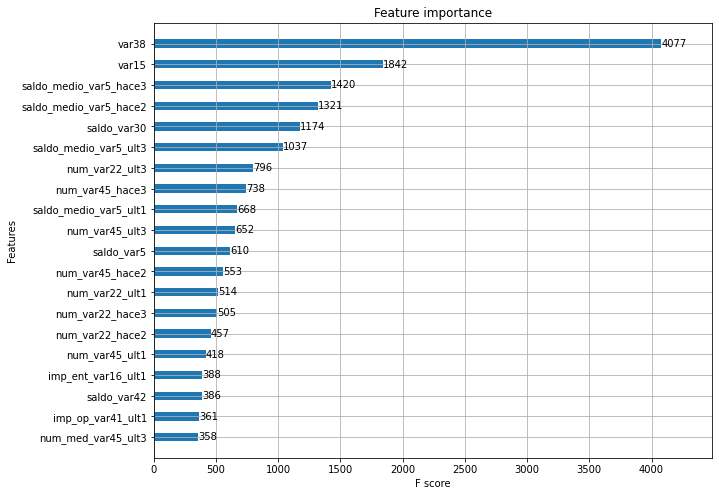

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

### 분류 실습 - 캐글 산탄데르 고객 만족 예측
### 3. LightGBM 모델 학습과 하이퍼 파라미터 튜닝
- XGBoost 예제 코드에서 만들어진 데이터 세트를 기반으로 LightGBM을 이용하여 모델을 학습하고 하이퍼 파라미터를 튜닝하여 예측 성능을 평가한다.
- 사이킷런 래퍼인 **`LGBMClassifier`**를 기반으로 학습을 수행한다.
- 앞의 XGBoost 예제와 동일하게 **`n_estimators`**=500, **`early_stopping_rounds`**=100, **`eval_metric`**은 'auc'로, 평가 데이터 세트는 테스트 데이터 세트로 설정한다.
- LightGBM 수행 결과 ROC-AUC가 약 **0.8396**으로 나타난다.
- LightGBM으로 수행하면 XGBoost보다 학습에 걸리는 시간이 단축되었음을 확인할 수 있다.

In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

evals = [(X_test, y_test)] # 평가 데이터 세트는 테스트 데이터 세트
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals, verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average='macro')

In [ ]:
print("ROC-AUC: {0:.4f}".format(lgbm_roc_score))

ROC-AUC: 0.8396


### 분류 실습 - 캐글 산탄데르 고객 만족 예측
### 3. LightGBM 모델 학습과 하이퍼 파라미터 튜닝
- **`GridSearchCV`**를 이용하여 다양한 하이퍼 파라미터에 대한 튜닝을 수행한다.
- 튜닝 대상은 **`num_leaves, max_depth, min_child_samples, subsample`**이다.
- 최적 하이퍼 파라미터는 {'max_depth': 128, 'min_child_samples': 100, 'num_leaves': 32, 'subsample': 0.8}이다.

In [ ]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 200으로 감소
lgbm_clf = LGBMClassifier(n_estimators=200)

params = {'num_leaves': [32, 64], 'max_depth': [ 128, 160], 'min_child_samples': [60, 100], 'subsample': [0.8, 1]}

gridcv = GridSearchCV(lgbm_clf, param_grid=params, cv=3) # cv는 3으로 지정
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average='macro')

In [ ]:
print("GridSearchCV 최적 파라미터:", gridcv.best_params_)
print("ROC-AUC: {0:.4f}".format(xgb_roc_score))

GridSearchCV 최적 파라미터: {'max_depth': 128, 'min_child_samples': 100, 'num_leaves': 32, 'subsample': 0.8}
ROC-AUC: 0.8456


### 분류 실습 - 캐글 산탄데르 고객 만족 예측
### 3. LightGBM 모델 학습과 하이퍼 파라미터 튜닝
- 최적 하이퍼 파라미터는 {'max_depth': 128, 'min_child_samples': 100, 'num_leaves': 32, 'subsample': 0.8}이다.
- 해당 하이퍼 파라미터를 LightGBM에 적용하고 다시 학습하여 ROC-AUC 측정 결과를 도출한다.
- LightGBM의 경우 테스트 데이터 세트에서 ROC-AUC가 약 **0.8456**으로 측정된다.

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=32, subsample=0.8, min_child_samples=100, max_depth=128)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals, verbose=True)

lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average='macro')

In [ ]:
print("ROC-AUC: {0:.4f}".format(xgb_roc_score))

ROC-AUC: 0.8456


### 분류 실습 - 캐글 신용카드 사기 검출
- 해당 데이터 세트의 레이블인 Class 속성은 0과 1로 분류되는데 0은 사기가 아닌 정상적인 신용카드 트랜잭션 데이터, 1은 신용카드 사기 트랜잭션을 의미한다.
- 전체 데이터의 약 0.172%만이 레이블 값이 1인 사기 트랜잭션으로, Class는 매우 불균형한 분포를 가지고 있다.
- 일반적으로 사기 검출이나 이상 검출과 같은 데이터 세트에서는 사기와 같은 이상 현상은 전체에서 차지하는 비중이 매우 적을 수밖에 없으므로, 이처럼 레이블 값이 극도로 불균형한 분포를 가지기 쉽다.

### 분류 실습 - 캐글 신용카드 사기 검출
### 1. 언더 샘플링과 오버 샘플링의 이해
- 레이블이 불균형한 분포를 가진 데이터 세트를 학습시킬 때 예측 성능의 문제가 발생할 수 있는데, 정상 레이블을 가진 데이터 건수에 비해 이상 레이블을 가지는 데이터 건수가 너무 적기 때문이다.
- 즉 이상 레이블을 가지는 데이터 건수는 매우 작기 때문에 제대로 다양한 유형을 학습하지 못하는 반면, 정상 레이블을 가지는 데이터 건수는 매우 많기 때문에 일방적으로 정상 레이블로 치우친 학습을 수행하여 제대로 된 이상 데이터 검출이 어려워지기 쉽다.
- 지도학습에서는 극도로 불균형한 레이블 값 분포로 인한 문제점을 해결하기 위해서는 적절한 학습 데이터를 확보하는 방안이 필요한데, 대표적으로 **오버 샘플링**과 **언더 샘플링** 방법이 있으며, 오버 샘플링 방법이 예측 성능상 더 유리한 경우가 많아 주로 사용된다.

> **언더 샘플링**(Undersampling)
 - 언더 샘플링은 **많은 데이터 세트를 적은 데이터 세트 수준으로 감소**시키는 방법이다.
 - 예를 들어 정상 레이블을 가진 데이터가 10000건, 이상 레이블을 가진 데이터가 100건이 있으면 정상 레이블 데이터를 100건으로 줄여버리는 방식이다.
 - 정상 레이블 데이터를 이상 레이블 데이터 수준으로 줄여버린 상태에서 학습을 수행하면 과도하게 정상 레이블로 학습 및 예측하는 부작용을 개선할 수 있지만, 너무 많은 정상 레이블 데이터를 감소시키므로 정상 레이블의 경우 오히려 제대로 된 학습을 수행할 수 없다는 단점이 있어 잘 적용하지 않는 방법이다.

> **오버 샘플링**(Oversampling)
 - 오버 샘플링은 **이상 데이터와 같이 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보**하는 방법이다.
 - 동일한 데이터를 단순히 증식하는 방법은 과적합되어 의미가 없으므로, **원본 데이터의 피처 값들을 아주 약간만 변경하여 증식**한다.
 - 대표적으로 SMOTE 방법이 있는데, 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃을 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터를 생성하는 방법이다.

### 분류 실습 - 캐글 신용카드 사기 검출
### 2. 데이터 전처리 및 모델 학습/예측/평가
- Time 피처의 경우는 데이터 생성 관련한 작업용 속성으로 큰 의미가 없으므로 드롭한다.
- Amount 피처는 신용카드 트랜잭션 금액을 의미하며, Class는 레이블로 0의 경우에는 정상, 1의 경우에는 사기 트랜잭션이다.
- 전체 284807개의 자료에서 결측치 값은 없으며, Class 레이블만 int형이고 나머지 피처들은 모두 float형이다.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

card_df = pd.read_csv("/content/drive/MyDrive/ESAA/data/creditcard.csv")
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [ ]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### 분류 실습 - 캐글 신용카드 사기 검출
### 2. 데이터 전처리 및 모델 학습/예측/평가
- 실습을 위해 인자로 입력된 DataFrame을 복사한 뒤 이를 가공하여 반환하는 get_preprocessed_df() 함수와 데이터 가공 후 학습 데이터 세트와 테스트 데이터 세트를 반환하는 get_train_test_dataset() 함수를 생성한다.
- get_preprocessed_df() 함수는 입력된 DataFrame을 복사하고 'Time' 칼럼을 드롭한다.
- get_train_test_dataset() 함수는 train_test_split() 함수를 호출하여 테스트 데이터 세트를 전체의 30%인 **Stratified 방식으로 추출**하여 학습 데이터 세트와 테스트 데이터 세트의 **레이블 값 분포도를 서로 동일**하게 생성한다.
- 생성한 학습 데이터 세트와 테스트 데이터 세트의 레이블 값 비율을 백분율로 환산하여 서로 비슷하게 분할되었는지 확인한다.
- 학습 데이터 세트 레이블의 경우 1값이 약 0.172%, 테스트 데이터 세트 레이블의 경우 1값이 약 0.173%로 큰 차이 없이 비슷하게 잘 분할되었다.

In [ ]:
# 인자로 입력된 DataFrame을 복사한 뒤 Time 칼럼만을 제거하고 복사된 DataFrame을 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

# 사전 데이터 가공 후 학습 데이터 세트와 테스트 데이터 세트를 반환
def get_train_test_dataset(df=None):
    # 사전 데이터 가공이 완료된 복사 DataFrame을 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 칼럼은 레이블, 나머지 칼럼은 피처
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split()으로 학습과 테스트 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target) # Stratified 기반 분할
    # 학습 데이터 세트와 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [ ]:
# 학습 데이터 세트와 테스트 데이터 세트의 레이블 값 비율을 백분율로 환산하여 서로 비슷하게 분할되었는지 확인
print("학습 데이터 세트 레이블 값 비율")
print(y_train.value_counts()/y_train.shape[0] * 100)
print("테스트 데이터 세트 레이블 값 비율")
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 세트 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 세트 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


### 분류 실습 - 캐글 신용카드 사기 검출
### 2. 데이터 전처리 및 모델 학습/예측/평가
- 로지스틱 회귀와 LightGBM 기반의 모델을 이용하여 학습과 예측을 수행하면서 예측 성능을 평가한다.
- 예측 성능 평가는 유틸리티 함수 get_clf_eval() 함수를 사용한다.
- 로지스틱 회귀는 **`LogisticRegression`** 클래스를 이용한다.

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(Y_test, pred, pred_proba):
    confusion = confusion_matrix(Y_test, pred)
    accuracy = accuracy_score(Y_test, pred)
    precision = precision_score(Y_test, pred)
    recall = recall_score(Y_test, pred)
    f1 = f1_score(Y_test, pred)
    roc_auc = roc_auc_score(Y_test, pred_proba)
    print("오차 행렬")
    print(confusion)
    print("정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}".format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85281    14]
 [   56    92]]
정확도: 0.9992, 정밀도: 0.8679, 재현율: 0.6216, F1: 0.7244, AUC: 0.9609


### 분류 실습 - 캐글 신용카드 사기 검출
### 2. 데이터 전처리 및 모델 학습/예측/평가
- 앞으로 모델 학습/예측/평가는 반복적으로 수행할 것이므로 이를 위한 별도의 함수를 생성한다.
- get_model_train_eval() 함수는 인자로 **사이킷런의 Estimator 객체**와 **학습 데이터 세트/테스트 데이터 세트**를 입력 받아서 **학습, 예측, 평가를 수행**한다.
- LightGBM은 **`LGBMClassifier`** 클래스를 이용한다.
- 주어진 데이터 세트는 극도로 불균형한 레이블 값 분포도를 가지고 있으므로 LightGBMClassifier 객체 생성시 `boost_from_average=False`로 파라미터를 설정한다.
- 로지스틱 회귀보다는 높은 수치를 나타낸다.

In [ ]:
# 인자로 사이킷런의 Estimator 객체와 학습 데이터 세트/테스트 데이터 세트를 입력 받아서 학습/예측/평가를 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635, F1: 0.8496, AUC: 0.9786


### 분류 실습 - 캐글 신용카드 사기 검출
### 3. 데이터 분포도 변환 후 모델 학습/예측/평가
- 왜곡된 분포도를 가지는 데이터를 재가공한 뒤에 모델을 다시 테스트한다.
- 데이터의 Amount 피처는 신용 카드 사용 금액으로 정상/사기 트랜잭션을 결정하는 매우 중요한 속성일 가능성이 높으므로, Amount 피처의 분포도를 확인한다.
- Amount, 즉 카드 사용 금액이 1000불 이하인 데이터가 대부분이며, 27000불까지 드물지만 많은 금액을 사용한 경우가 발생하면서 꼬리가 긴 형태의 분포 곡선을 나타낸다.

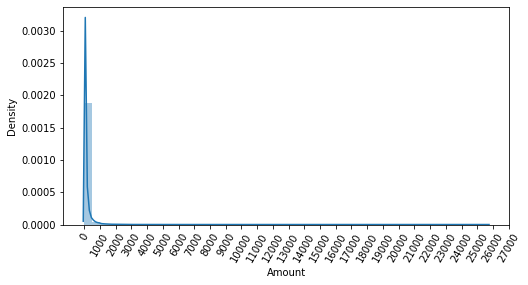

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

### 분류 실습 - 캐글 신용카드 사기 검출
### 3. 데이터 분포도 변환 후 모델 학습/예측/평가
- Amount 값을 **표준 정규 분포 형태로 변환**한 뒤에 로지스틱 회귀와 LightGBM의 예측 성능을 측정한다.
- 앞에서 만든 get_preprocessed_df() 함수를 사이킷런의 **`StandardScaler`** 클래스를 이용하여 Amount 피처를 정규 분포 형태로 변환하는 로직으로 변경한다.
- 수정한 get_preprocessed_df() 함수가 반영된 get_train_test_dataset()을 호출하여 학습 데이터 세트와 테스트 데이터 세트를 생성한 후에 get_model_train_eval()를 이용하여 로지스틱 회귀와 LigthGBM 모델을 각각 학습/예측/평가한다.
- 두 모델 모두 Amount 피처값을 정규 분포 형태로 변환하기 이전과 비교하여 성능이 크게 개선되지는 않았다.

In [ ]:
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    # Amount 칼럼을 정규 분포로 변환
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    # 변환된 Amount를 Amount_Scaled로 피처명을 변경한 후 DataFrame의 맨 앞 칼럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 칼럼 삭제
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

# 사전 데이터 가공 후 학습 데이터 세트와 테스트 데이터 세트를 반환
def get_train_test_dataset(df=None):
    # 사전 데이터 가공이 완료된 복사 DataFrame을 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 칼럼은 레이블, 나머지 칼럼은 피처
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split()으로 학습과 테스트 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target) # Stratified 기반 분할
    # 학습 데이터 세트와 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

In [ ]:
# Amount를 정규 분포 형태로 변환 후 학습 데이터 세트와 테스트 데이터 세트 생성
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

# 로지스틱 회귀 학습/예측/평가 수행
print("### 로지스틱 회귀 예측 성능 ###")
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

# LigthGBM 학습/예측/평가 수행
print("### LightGBM 예측 성능 ###")
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081, F1: 0.7143, AUC: 0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85263    32]
 [  107    41]]
정확도: 0.9984, 정밀도: 0.5616, 재현율: 0.2770, F1: 0.3710, AUC: 0.6383


### 분류 실습 - 캐글 신용카드 사기 검출
### 3. 데이터 분포도 변환 후 모델 학습/예측/평가
- 이번에는 표준화 대신 **로그 변환**을 수행하는데, 로그 변환은 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법 중 하나이다.
- 원래 값을 log 값으로 변환하므로 원래의 큰 값을 상대적으로 작은 값으로 변환한기 때문에 데이터 분포도의 왜곡을 상당 수준 개선한다.
- 로그 변환은 넘파이의 **`log1p()`** 함수를 이용하여 변환이 가능하다.
- 데이터 가공 함수인 get_preprocessed_df()를 로그 변환 로직으로 변경한다.
- Amount 피처를 로그 변환한 후 다시 로지스틱 회귀와 LightGBM 모델을 적용한 후 예측 성능을 확인한다.
- 두 모델 모두 정밀도, 재현율, ROC-AUC에서 약간씩 성능이 개선되었다.

In [ ]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p()를 이용하여 Amount 칼럼을 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    # 변환된 Amount를 Amount_Scaled로 피처명을 변경한 후 DataFrame의 맨 앞 칼럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 칼럼 삭제
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

# 사전 데이터 가공 후 학습 데이터 세트와 테스트 데이터 세트를 반환
def get_train_test_dataset(df=None):
    # 사전 데이터 가공이 완료된 복사 DataFrame을 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 칼럼은 레이블, 나머지 칼럼은 피처
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split()으로 학습과 테스트 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target) # Stratified 기반 분할
    # 학습 데이터 세트와 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

In [ ]:
# Amount를 정규 분포 형태로 변환 후 학습 데이터 세트와 테스트 데이터 세트 생성
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

# 로지스틱 회귀 학습/예측/평가 수행
print("### 로지스틱 회귀 예측 성능 ###")
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

# LigthGBM 학습/예측/평가 수행
print("### LightGBM 예측 성능 ###")
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, F1: 0.7149, AUC: 0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85266    29]
 [   65    83]]
정확도: 0.9989, 정밀도: 0.7411, 재현율: 0.5608, F1: 0.6385, AUC: 0.7801


### 분류 실습 - 캐글 신용카드 사기 검출
### 4. 이상치 데이터 제거 후 모델 학습/예측/평가
- 이상치 데이터(Outlier)는 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터로, 이상치로 인해 머신러닝 모델의 성능에 영향을 받는 경우가 발생하기 쉽다.
- 이상치를 찾는 방법은 여러 가지가 있지만, 이 중에서 IQR(Inter Quantile Range) 방식은 사분위 값의 편차를 이용하는 기법으로 흔히 박스 플롯(Box Plot) 방식으로 시각화할 수 있다.
- 사분위는 전체 데이터를 값이 높은 순으로 정렬하고 이를 1/4(25%)씩 구간을 분할하여 각 구간을 Q1, Q2, Q3, Q4로 지칭하는 것이다. 이들 중 25% 구간인 Q1부터 75% 구간인 Q3까지의 범위를 IQR이라고 한다.
- IQR을 이용하여 이상치 데이터를 검출하는 방식은 보통 **IQR에 1.5를 곱해서 생성된 범위**를 이용하여 최댓값과 최솟값을 결정한 뒤, **최댓값을 초과하거나 최솟값에 미달하는 데이터를 이상치로 간주**하는 것이다.
- IQR을 이용하여 이상치를 제거하기 위해서는 먼저 어떤 피처의 이상치 데이터를 검출할 것인지 선택해야 한다. 매우 많은 피처가 있을 경우 이들 중 결정값인 **레이블과 가장 상관성이 높은 피처들을 위주로 이상치를 검출**하는 것이 좋다. 모든 피처들의 이상치를 검출하는 것은 많은 시간이 소요되며, 결정값과 상관성이 높지 않은 피처들의 경우 이상치를 제거하더라도 크게 성능 향상에 기여하지 않기 때문이다.
- DataFrame의 **`corr()`** 함수를 이용하여 각 피처별로 상관도를 구한 뒤, seaborn의 heatmap을 통해 시각화한다.

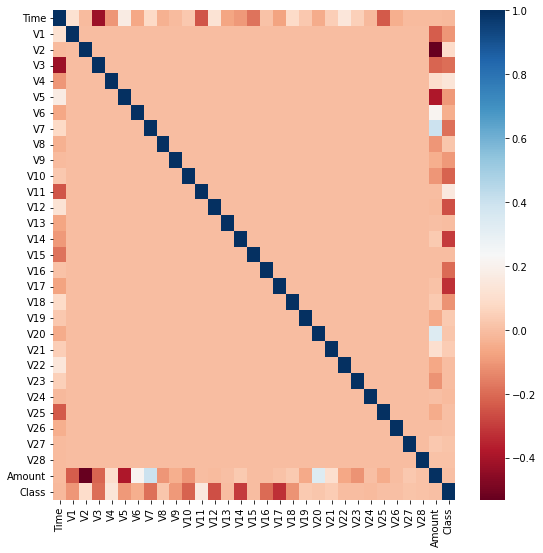

In [ ]:
plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap="RdBu")

### 분류 실습 - 캐글 신용카드 사기 검출
### 4. 이상치 데이터 제거 후 모델 학습/예측/평가
- 상관관계 히트맵에서 `cmap`을 "RdBu"로 지정하여 **양의 상관관계**가 높을수록 색깔이 **진한 파란색**에 가까우며, **음의 상관관계**가 높을수록 색깔이 **진한 빨강색**에 가깝게 표현된다.
- 가장 마지막에 위치한 결정 레이블 Class 피처와 음의 상관관계가 가장 높은 피처는 V14와 V17이며, 이중 V14에 대하여 이상치를 찾아서 제거한다.
- IQR을 이용하여 이상치를 검출하는 함수 get_outlier()를 생성하고, 이를 이용하여 검출된 이상치를 삭제한다.
- get_outlier() 함수는 인자로 DataFrame과 이상치를 검출할 칼럼을 입력 받고, 함수 내에서 넘파이의 **`percentile()`**을 이용하여 1/4 분위(Q1)와 3/4 분위(Q3)을 구하고 이에 기반하여 IQR을 계산한다. 계산된 IQR에 1.5를 곱해서 최댓값과 최솟값 지점을 구하고, 최댓값보다 크거나 최솟값보다 작은 값을 이상치로 설정하고 해당 이상치가 있는 DataFrame의 Index를 반환한다.
- 총 4개의 데이터인 8296, 8615, 9035, 9252번 Index가 이상치로 추출되었다.

In [ ]:
def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출
    fraud = df[df['Class']==1][column]
    # 1/4 분위와 3/4 분위 지점을 np.percentile로 구함
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR를 구하고, 1.5를 곱해 최댓값과 최솟값 지점을 구함
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight # 최솟값
    highest_val = quantile_75 + iqr_weight # 최댓값
    # 최댓값보다 크거나 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame Index를 반환
    outlier_index = fraud[ (fraud < lowest_val) | (fraud > highest_val) ].index
    return outlier_index

outlier_index = get_outlier(df=card_df, column="V14", weight=1.5)
print("이상치 데이터 인덱스:", outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


### 분류 실습 - 캐글 신용카드 사기 검출
### 4. 이상치 데이터 제거 후 모델 학습/예측/평가
- 데이터 가공함수인 get_preprocessed_df()에 get_outlier()를 이용하여 이상치를 추출하고 이를 삭제하는 로직을 추가하여 데이터를 가공한다.
- get_train_test_dataset() 함수를 이용하여 학습 데이터 세트와 테스트 데이터 세트를 생성하고, get_model_train_eval() 함수를 이용하여 로지스틱 회귀와 LightGBM 모델을 다시 적용하여 예측 성능을 평가한다.

In [ ]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p()를 이용하여 Amount 칼럼을 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    # 변환된 Amount를 Amount_Scaled로 피처명을 변경한 후 DataFrame의 맨 앞 칼럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 칼럼 삭제
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    # 이상치 데이터를 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column="V14", weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

# 사전 데이터 가공 후 학습 데이터 세트와 테스트 데이터 세트를 반환
def get_train_test_dataset(df=None):
    # 사전 데이터 가공이 완료된 복사 DataFrame을 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 칼럼은 레이블, 나머지 칼럼은 피처
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split()으로 학습과 테스트 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target) # Stratified 기반 분할
    # 학습 데이터 세트와 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

# 로지스틱 회귀 학습/예측/평가 수행
print("### 로지스틱 회귀 예측 성능 ###")
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

# LigthGBM 학습/예측/평가 수행
print("### LightGBM 예측 성능 ###")
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, F1: 0.7597, AUC: 0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85233    62]
 [  110    36]]
정확도: 0.9980, 정밀도: 0.3673, 재현율: 0.2466, F1: 0.2951, AUC: 0.6229


### 분류 실습 - 캐글 신용카드 사기 검출
### 5. SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가
- SMOTE를 적용할 때는 반드시 **학습 데이터 세트만 오버 샘플링**을 해야 하는데, 검증 데이터 세트나 테스트 데이터 세트를 오버 샘플링할 경우 결국은 원본 데이터 세트가 아닌 데이터 세트에서 검증/테스트를 수행하기 때문에 올바른 검증/테스트가 될 수 없기 때문이다.
- 앞에서 생성한 학습 피처 데이터와 레이블 데이터를 **SMOTE** 객체의 **`fit_resample()`** 메서드를 이용하여 증식한 뒤, 데이터를 증식 전과 비교한다.
- SMOTE 적용 전 학습 데이터 세트는 199362건이었지만, SMOTE 적용 후 2배에 가까운 398040건으로 데이터가 증식되었다. 그리고 SMOTE 적용 후 레이블 값이 0과 1의 분포가 동일하게 199020건으로 생성되었다.
- 이렇게 생성된 학습 데이터 세트를 기반으로 먼저 로지스틱 회귀 모델을 학습한 뒤 성능을 평가한다.

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

print("SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ", X_train.shape, y_train.shape)
print("SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ", X_train_over.shape, y_train_over.shape)
print("SMOTE 적용 후 레이블 값 분포: \n", pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


In [ ]:
lr_clf = LogisticRegression()
# ftr_train과 tgt_train의 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247, F1: 0.1023, AUC: 0.9737


### 분류 실습 - 캐글 신용카드 사기 검출
### 5. SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가
- 로지스틱 회귀 모델의 경우 SMOTE로 오버 샘플링된 데이터로 학습할 경우 재현율이 92.47%로 크게 증가하지만, 반대로 정밀도가 5.4%로 급격하게 저하된다.
- 이는 로지스틱 회귀 모델이 오버 샘플링으로 인해 실제 원본 데이터의 유형보다 너무나 많은 Class=1 데이터를 학습하면서, 실제 테스트 데이터 세트에서 예측을 지나치게 Class=1로 적용하여 정밀도가 급격하게 떨어지게 된 것이다.
- 분류 결정 임계값에 따른 정밀도와 재현율 곡선을 그려주는 precision_recall_curve_plot() 함수를 통해 SMOTE로 학습된 로지스틱 회귀 모델에 발생하는 문제점을 시각적으로 확인할 수 있다.
- 임계값이 0.99 이하에서는 재현율이 매우 좋고 정밀도가 극단적으로 낮다가 0.99 이상에서는 반대로 재현율이 대폭 떨어지고 정밀도가 높아진다.
- 분류 결정 임계값을 조정하더라도 임계값의 민감도가 너무 심해 올바른 재현율/정밀도 성능을 얻을 수 없으므로 로지스틱 회귀 모델의 경우 SMOTE 적용 후 올바른 예측 모델이 생성되지 못 했다.

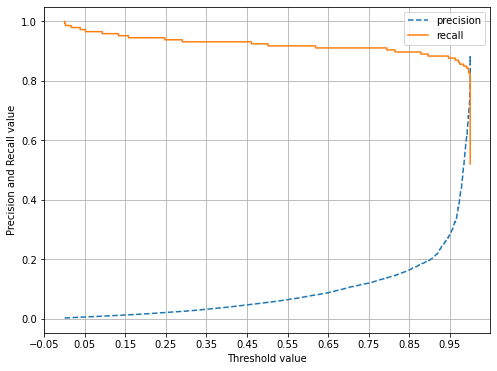

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(Y_test, pred_proba_c1):
    # 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 입력하여 threshold array와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(Y_test, pred_proba_c1)

    # X축을 threshold 값으로, Y축은 정밀도, 재현율 값으로 각각 plot 수행하고 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

    # threshold 값 X축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    # X축, Y축 label과 legend, grid 설정
    plt.xlabel("Threshold value")
    plt.ylabel("Precision and Recall value")
    plt.legend()
    plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

### 분류 실습 - 캐글 신용카드 사기 검출
### 5. SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가
- LigthGBM 모델을 이용하여 SMOTE로 오버 샘플링된 데이터 세트로 학습/예측/평가를 수행한다.

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85286     9]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9323, 재현율: 0.8493, F1: 0.8889, AUC: 0.9789


### 분류 실습 - 캐글 신용카드 사기 검출
### 5. SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가
- 일반적으로 SMOTE를 적용하면 재현율은 높아지나, 정밀도는 낮아진다.
- 좋은 SMOTE 패키지일수록 재현율 증가율은 높이고 정밀도 감소율은 낮출 수 있도록 효과적으로 데이터를 증식한다.